# MD Fakrul Islam, Certified Data Scientist, Machine Learning, Deep Learning   Engineer and Big Data Professional
# Email: fakruldsebd@gmail.com
# Phone: +8801954345775
# https://www.linkedin.com/in/fakrul-islam-bd/
# https://github.com/aifakrul
## Contact for nlp/nlu, image, audio/speech, video processing and contextual ai in real time to solve your complex **Business AI Problem**

# Project Details


```
Identify diseases of below plants using convolutional neural networks (CNN), transfer learning strategy and multilevel classifications. 

Apple- 3 Deadly diseases
Grape- 3 Deadly diseases
Maize- 3 Deadly diseases
Potato- 2 Deadly diseases
Tomato- 9 Deadly diseases


You can collect the Dataset from my Google Drive:
https://drive.google.com/file/d/1odLdFTMf_U-SkCTa0JIWmzVFTmV14paO/view?usp=sharing


Assess the top layer accuracy of:

MobileNetV2
ResNet50V2
ResNet101V2
ResNet152V2
Xception
VGG16
VGG19
InceptionResNetV2
InceptionV3

To learn about the CNN, please visit

https://arxiv.org/
https://en.wikipedia.org/wiki/Convolutional_neural_network
https://www.tensorflow.org/federated

```



# Import Necessery Library

In [1]:
import os, sys, math, time
import numpy as np
from matplotlib import pyplot as plt
if 'google.colab' in sys.modules: 
  %tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.2.0


# Mount the google drive drive to fetch datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Split Dataset into Training and Validation

In [3]:
IMAGE_FILE_LOCATION = '/content/drive/My Drive/Plant_Disease_Clinic/Apple/*/*.JPG'
TF_RECORD_LOCATION = '/content/drive/My Drive/Plant_Disease_Clinic/apple_tfrecords/*.tfrec'

IMAGE_SIZE = [224, 224]

BATCH_SIZE = 64 # 128 works on GPU too but comes very close to the memory limit of the Colab GPU
EPOCHS=12

VALIDATION_SPLIT = 0.20
CLASSES = [b'Black_Rot', b'Cedar_Rust', b'Healthy', b'Scab' ] # do not change, maps to the labels in the data (folder names)
NO_OF_CLASSES=len(CLASSES)

total_image_files = len(tf.io.gfile.glob(IMAGE_FILE_LOCATION))

# splitting data files between training and validation
filenames = tf.io.gfile.glob(TF_RECORD_LOCATION)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(total_image_files // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(total_image_files // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

#print(NO_OF_CLASSES)
#print(filenames)
#print(len(filenames))
#print(len(validation_filenames))
#print(len(training_filenames))
#print(validation_steps)
#print(steps_per_epoch)
#print(CLASSES)
#print(validation_filenames)
#print(training_filenames)

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 44 batches per training epoch and 10 batch(es) per validation run.


# Configure all utilities function

In [4]:
def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[labels[i]]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

#Read images and labels from TFRecords

In [5]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    class_label = example['class']
    return image, class_label

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

# Display 9 images from training files

['/content/drive/My Drive/Plant_Disease_Clinic/apple_tfrecords/apple03-219.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/apple_tfrecords/apple04-219.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/apple_tfrecords/apple05-219.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/apple_tfrecords/apple06-219.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/apple_tfrecords/apple07-219.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/apple_tfrecords/apple08-219.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/apple_tfrecords/apple09-219.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/apple_tfrecords/apple10-219.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/apple_tfrecords/apple11-219.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/apple_tfrecords/apple12-219.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/apple_tfrecords/apple13-219.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/apple_tfrecords/apple14-219.tfrec', '/content/drive

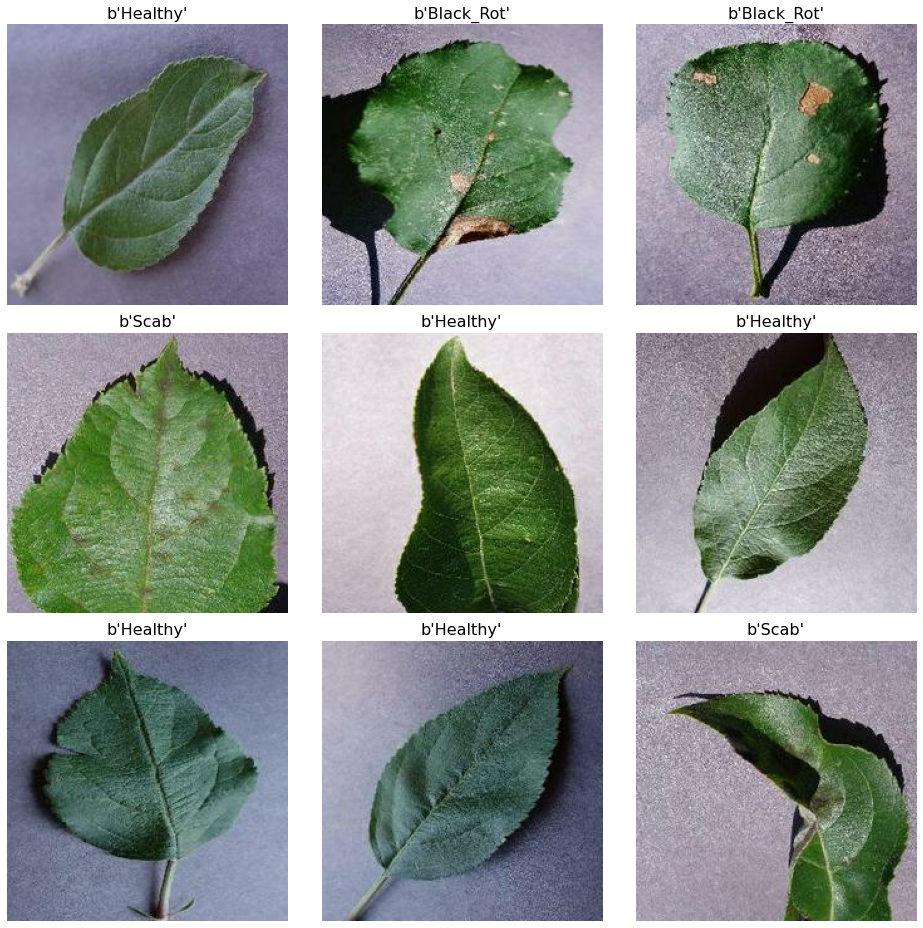

In [6]:
print(training_filenames)
display_9_images_from_dataset(load_dataset(training_filenames))

# Display 9 images from validation files

['/content/drive/My Drive/Plant_Disease_Clinic/apple_tfrecords/apple00-219.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/apple_tfrecords/apple01-219.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/apple_tfrecords/apple02-219.tfrec']


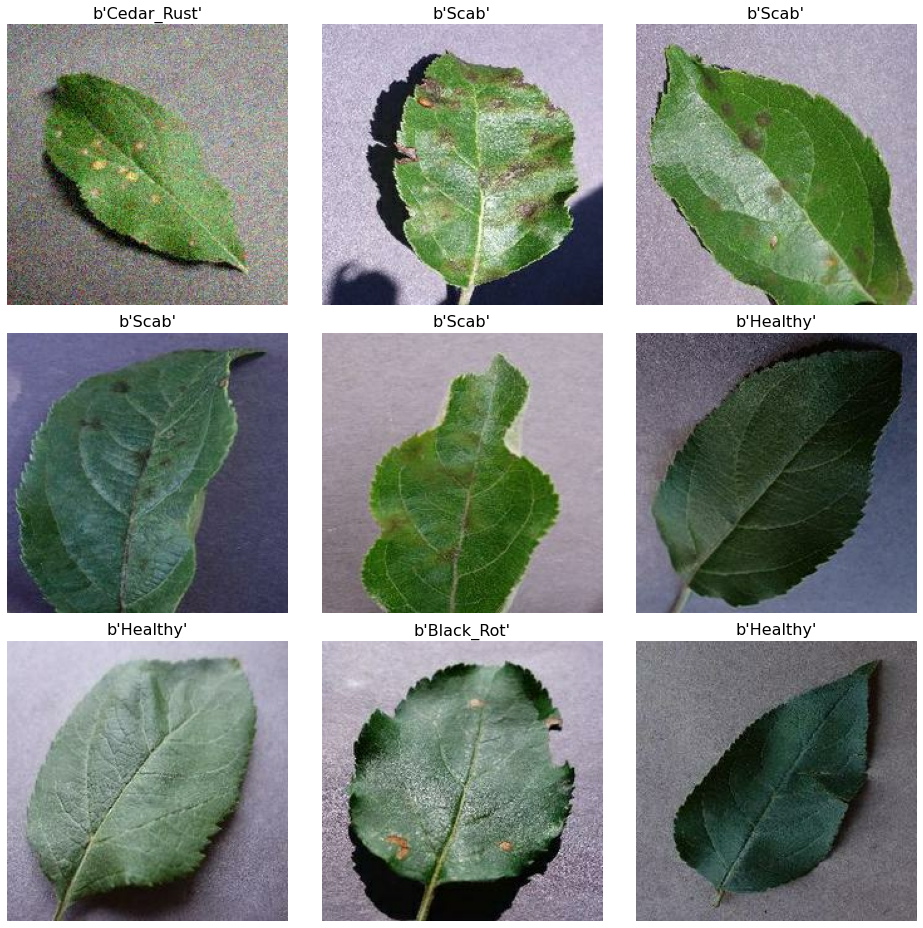

In [7]:
print(validation_filenames)
display_9_images_from_dataset(load_dataset(validation_filenames))

# Prepare training and validation datasets and Load into RAM

In [8]:
def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

print(training_dataset)
print(validation_dataset)


<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>


# Model Creation(MobileNetV2)

In [9]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_MobileNetV2 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_MobileNetV2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_MobileNetV2.summary()
model_MobileNetV2.input_shape

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               16056576  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 18,315,588
Trainable params: 16,057,604
Non-trainable params: 2,257,984
_________________________________________________________________


(None, 224, 224, 3)

# All Popular ResNet Models
# Model Creation (ResNet50V2)

In [10]:
pretrained_model = tf.keras.applications.ResNet50V2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_ResNet50V2 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_ResNet50V2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_ResNet50V2.summary()
model_ResNet50V2.input_shape

94674944/94668760 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 49,256,196
Trainable params: 25,691,396
Non-trainable params: 23,564,800
_________________________________________________________________


(None, 224, 224, 3)

# Model Creation (ResNet101V2)

In [11]:
pretrained_model = tf.keras.applications.ResNet101V2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_ResNet101V2 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_ResNet101V2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_ResNet101V2.summary()
model_ResNet101V2.input_shape

171319296/171317808 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Model)          (None, 7, 7, 2048)        42626560  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 68,317,956
Trainable params: 25,691,396
Non-trainable params: 42,626,560
_________________________________________________________________


(None, 224, 224, 3)

# Model Creation (ResNet152V2)

In [12]:
pretrained_model = tf.keras.applications.ResNet152V2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_ResNet152V2 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_ResNet152V2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_ResNet152V2.summary()
model_ResNet152V2.input_shape

234553344/234545216 [==============================] - 2s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 7, 7, 2048)        58331648  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 1028      
Total params: 84,023,044
Trainable params: 25,691,396
Non-trainable params: 58,331,648
_________________________________________________________________


(None, 224, 224, 3)

# Model Creation Xception

In [13]:
pretrained_model = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_Xception = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_Xception.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_Xception.summary()
model_Xception.input_shape

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_4 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 1028      
Total params: 46,552,876
Trainable params: 25,691,396
Non-trainable params: 20,861,480
_________________________________________________________________


(None, 224, 224, 3)

# All VGG Models
# Model Creation VGG16

In [14]:
pretrained_model = tf.keras.applications.VGG16(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_VGG16 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_VGG16.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_VGG16.summary()
model_VGG16.input_shape

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 1028      
Total params: 21,138,500
Trainable params: 6,423,812
Non-trainable params: 14,714,688
_________________________________________________________________


(None, 224, 224, 3)

# Model Creation VGG19

In [15]:
pretrained_model = tf.keras.applications.VGG19(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_VGG19 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_VGG19.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_VGG19.summary()
model_VGG19.input_shape

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 1028      
Total params: 26,448,196
Trainable params: 6,423,812
Non-trainable params: 20,024,384
_________________________________________________________________


(None, 224, 224, 3)

# Model Creation InceptionResNetV2

In [16]:
pretrained_model = tf.keras.applications.InceptionResNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_InceptionResNetV2 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_InceptionResNetV2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_InceptionResNetV2.summary()
model_InceptionResNetV2.input_shape

219062272/219055592 [==============================] - 3s 0us/step
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_7 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               9830656   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 1028      
Total params: 64,168,420
Trainable params: 9,831,684
Non-trainable params: 54,336,736
_________________________________________________________________


(None, 224, 224, 3)

# Model Creation InceptionV3

In [17]:
pretrained_model = tf.keras.applications.InceptionV3(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_InceptionV3 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_InceptionV3.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_InceptionV3.summary()
model_InceptionV3.input_shape

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_8 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 1028      
Total params: 34,911,268
Trainable params: 13,108,484
Non-trainable params: 21,802,784
_________________________________________________________________


(None, 224, 224, 3)

In [18]:
# Create List to store Training Time, Training Accuracy, Training Loss, Validation Accuracy, Validation Loss
training_details=[]

#Train the model(MobileNetV2)

In [19]:
start_time = time.time()
history = model_MobileNetV2.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]
model_MobileNetV2_accuracy=round(np.mean(final_accuracy),2)
model_MobileNetV2_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(MobileNetV2): ", model_MobileNetV2_accuracy)
print("TRAINING TIME: ", model_MobileNetV2_training_time , " sec")

Epoch 1/12
44/44 [==============================] - 10s 222ms/step - loss: 2.0304 - accuracy: 0.8761 - val_loss: 0.2343 - val_accuracy: 0.9625
Epoch 2/12
44/44 [==============================] - 9s 199ms/step - loss: 0.1606 - accuracy: 0.9627 - val_loss: 0.0796 - val_accuracy: 0.9828
Epoch 3/12
44/44 [==============================] - 9s 201ms/step - loss: 0.0943 - accuracy: 0.9744 - val_loss: 0.0399 - val_accuracy: 0.9937
Epoch 4/12
44/44 [==============================] - 9s 199ms/step - loss: 0.0818 - accuracy: 0.9801 - val_loss: 0.0472 - val_accuracy: 0.9828
Epoch 5/12
44/44 [==============================] - 9s 198ms/step - loss: 0.0673 - accuracy: 0.9851 - val_loss: 0.0727 - val_accuracy: 0.9734
Epoch 6/12
44/44 [==============================] - 9s 199ms/step - loss: 0.0596 - accuracy: 0.9851 - val_loss: 0.0636 - val_accuracy: 0.9875
Epoch 7/12
44/44 [==============================] - 9s 201ms/step - loss: 0.0714 - accuracy: 0.9833 - val_loss: 0.0607 - val_accuracy: 0.9859
Epoch

# Training and Validation Accuracy Graph(MobileNetv2)
# Training and Validation Loss Graph(MobileNetv2)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


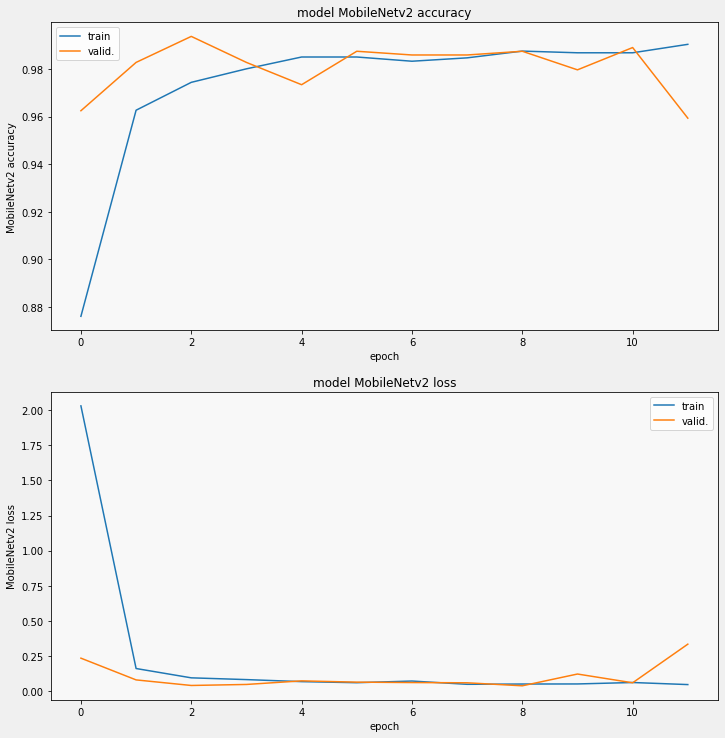

In [20]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'MobileNetv2 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'MobileNetv2 loss', 212)

# Train the model(ResNet50V2)

In [21]:
start_time = time.time()
history = model_ResNet50V2.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]
model_ResNet50V2_accuracy=round(np.mean(final_accuracy),2)
model_ResNet50V2_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(ResNet50V2): ", model_ResNet50V2_accuracy)
print("TRAINING TIME: ", model_ResNet50V2_training_time , " sec")


Epoch 1/12
44/44 [==============================] - 22s 506ms/step - loss: 3.1926 - accuracy: 0.8303 - val_loss: 0.1488 - val_accuracy: 0.9766
Epoch 2/12
44/44 [==============================] - 21s 483ms/step - loss: 0.1680 - accuracy: 0.9627 - val_loss: 0.1141 - val_accuracy: 0.9688
Epoch 3/12
44/44 [==============================] - 21s 479ms/step - loss: 0.0807 - accuracy: 0.9759 - val_loss: 0.0772 - val_accuracy: 0.9781
Epoch 4/12
44/44 [==============================] - 21s 475ms/step - loss: 0.0430 - accuracy: 0.9869 - val_loss: 0.0905 - val_accuracy: 0.9781
Epoch 5/12
44/44 [==============================] - 21s 477ms/step - loss: 0.0467 - accuracy: 0.9862 - val_loss: 0.1159 - val_accuracy: 0.9734
Epoch 6/12
44/44 [==============================] - 21s 478ms/step - loss: 0.0455 - accuracy: 0.9869 - val_loss: 0.1270 - val_accuracy: 0.9781
Epoch 7/12
44/44 [==============================] - 21s 479ms/step - loss: 0.0311 - accuracy: 0.9918 - val_loss: 0.0901 - val_accuracy: 0.9797

# Training and Validation Accuracy Graph(ResNet50V2)
# Training and Validation Loss Graph(ResNet50V2)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


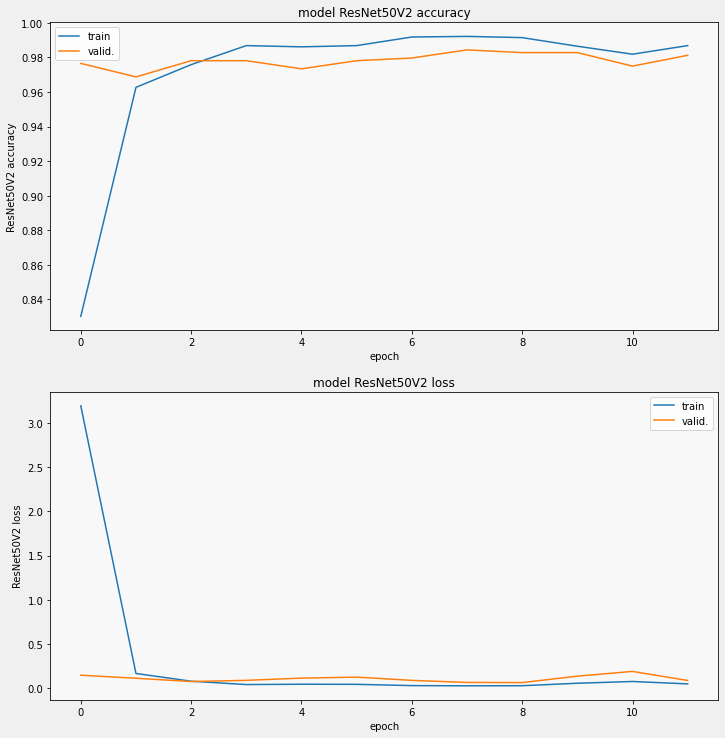

In [22]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'ResNet50V2 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'ResNet50V2 loss', 212)

# Train the model(ResNet101V2)

In [23]:
start_time = time.time()
history = model_ResNet101V2.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]
model_ResNet101V2_accuracy=round(np.mean(final_accuracy),2)
model_ResNet101V2_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(ResNet101V2): ", model_ResNet101V2_accuracy)
print("TRAINING TIME: ", model_ResNet101V2_training_time , " sec")

Epoch 1/12
44/44 [==============================] - 39s 887ms/step - loss: 4.0853 - accuracy: 0.8121 - val_loss: 0.1430 - val_accuracy: 0.9672
Epoch 2/12
44/44 [==============================] - 37s 844ms/step - loss: 0.1784 - accuracy: 0.9421 - val_loss: 0.0790 - val_accuracy: 0.9797
Epoch 3/12
44/44 [==============================] - 37s 844ms/step - loss: 0.1175 - accuracy: 0.9652 - val_loss: 0.0676 - val_accuracy: 0.9766
Epoch 4/12
44/44 [==============================] - 37s 846ms/step - loss: 0.0866 - accuracy: 0.9744 - val_loss: 0.0504 - val_accuracy: 0.9859
Epoch 5/12
44/44 [==============================] - 37s 841ms/step - loss: 0.0643 - accuracy: 0.9826 - val_loss: 0.0341 - val_accuracy: 0.9891
Epoch 6/12
44/44 [==============================] - 37s 839ms/step - loss: 0.0670 - accuracy: 0.9833 - val_loss: 0.0387 - val_accuracy: 0.9844
Epoch 7/12
44/44 [==============================] - 37s 841ms/step - loss: 0.0516 - accuracy: 0.9801 - val_loss: 0.0680 - val_accuracy: 0.9797

# Training and Validation Accuracy Graph(ResNet101V2)
# Training and Validation Loss Graph(ResNet101V2)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


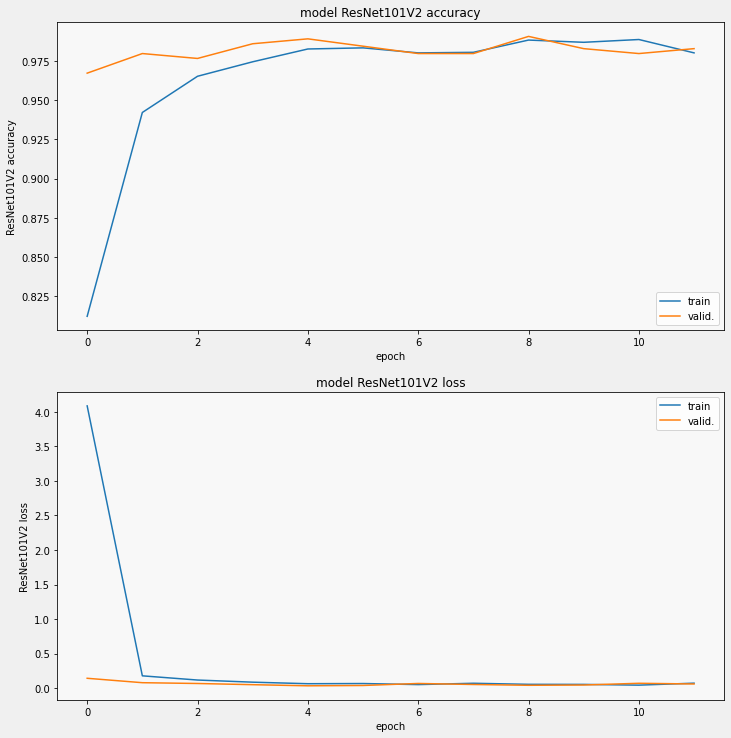

In [24]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'ResNet101V2 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'ResNet101V2 loss', 212)

# Train the model(ResNet152V2)

In [25]:
start_time = time.time()
history = model_ResNet152V2.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]

model_ResNet152V2_accuracy=round(np.mean(final_accuracy),2)
model_ResNet152V2_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(ResNet152V2): ", model_ResNet152V2_accuracy)
print("TRAINING TIME: ", model_ResNet152V2_training_time , " sec")

Epoch 1/12
44/44 [==============================] - 56s 1s/step - loss: 4.6401 - accuracy: 0.8033 - val_loss: 0.1844 - val_accuracy: 0.9406
Epoch 2/12
44/44 [==============================] - 53s 1s/step - loss: 0.2274 - accuracy: 0.9375 - val_loss: 0.0951 - val_accuracy: 0.9750
Epoch 3/12
44/44 [==============================] - 54s 1s/step - loss: 0.1139 - accuracy: 0.9648 - val_loss: 0.1193 - val_accuracy: 0.9750
Epoch 4/12
44/44 [==============================] - 54s 1s/step - loss: 0.0649 - accuracy: 0.9773 - val_loss: 0.0863 - val_accuracy: 0.9734
Epoch 5/12
44/44 [==============================] - 54s 1s/step - loss: 0.0535 - accuracy: 0.9794 - val_loss: 0.0742 - val_accuracy: 0.9828
Epoch 6/12
44/44 [==============================] - 54s 1s/step - loss: 0.0572 - accuracy: 0.9805 - val_loss: 0.0780 - val_accuracy: 0.9797
Epoch 7/12
44/44 [==============================] - 54s 1s/step - loss: 0.0616 - accuracy: 0.9815 - val_loss: 0.0517 - val_accuracy: 0.9828
Epoch 8/12
44/44 [==

# Training and Validation Accuracy Graph(ResNet152V2)
# Training and Validation Loss Graph(ResNet152V2)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


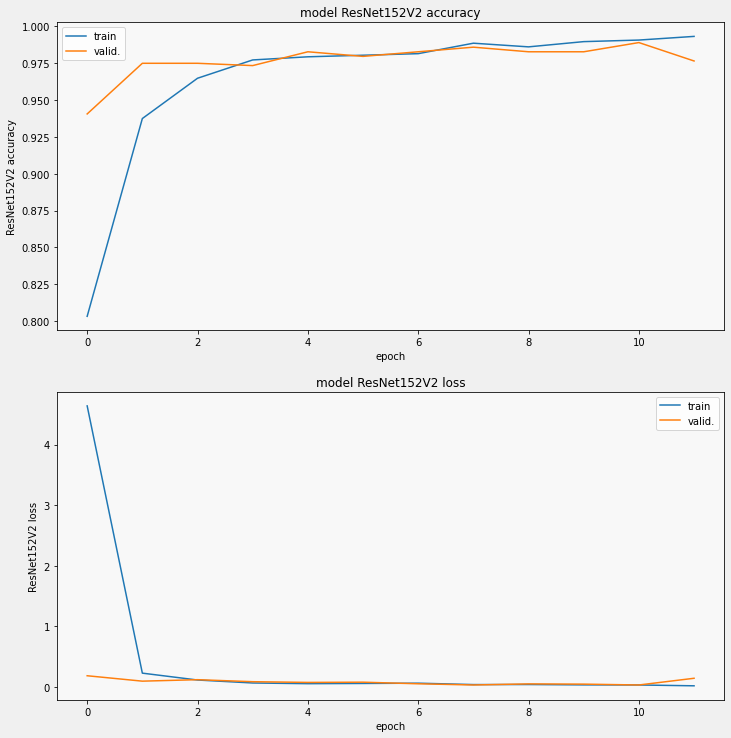

In [26]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'ResNet152V2 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'ResNet152V2 loss', 212)

# Train the model(Xception)

In [27]:
start_time = time.time()
history = model_Xception.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]

model_Xception_accuracy=round(np.mean(final_accuracy),2)
model_Xception_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(Xception): ", model_Xception_accuracy)
print("TRAINING TIME: ", model_Xception_training_time , " sec")

Epoch 1/12
44/44 [==============================] - 37s 848ms/step - loss: 2.7673 - accuracy: 0.7532 - val_loss: 0.2171 - val_accuracy: 0.9125
Epoch 2/12
44/44 [==============================] - 36s 819ms/step - loss: 0.2806 - accuracy: 0.9034 - val_loss: 0.1432 - val_accuracy: 0.9391
Epoch 3/12
44/44 [==============================] - 36s 822ms/step - loss: 0.1641 - accuracy: 0.9442 - val_loss: 0.1033 - val_accuracy: 0.9719
Epoch 4/12
44/44 [==============================] - 36s 825ms/step - loss: 0.1415 - accuracy: 0.9503 - val_loss: 0.1113 - val_accuracy: 0.9547
Epoch 5/12
44/44 [==============================] - 36s 828ms/step - loss: 0.1254 - accuracy: 0.9588 - val_loss: 0.1155 - val_accuracy: 0.9625
Epoch 6/12
44/44 [==============================] - 36s 829ms/step - loss: 0.0998 - accuracy: 0.9641 - val_loss: 0.0785 - val_accuracy: 0.9672
Epoch 7/12
44/44 [==============================] - 36s 829ms/step - loss: 0.0745 - accuracy: 0.9762 - val_loss: 0.1003 - val_accuracy: 0.9672

# Training and Validation Accuracy Graph(model_Xception)
# Training and Validation Loss Graph(model_Xception)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


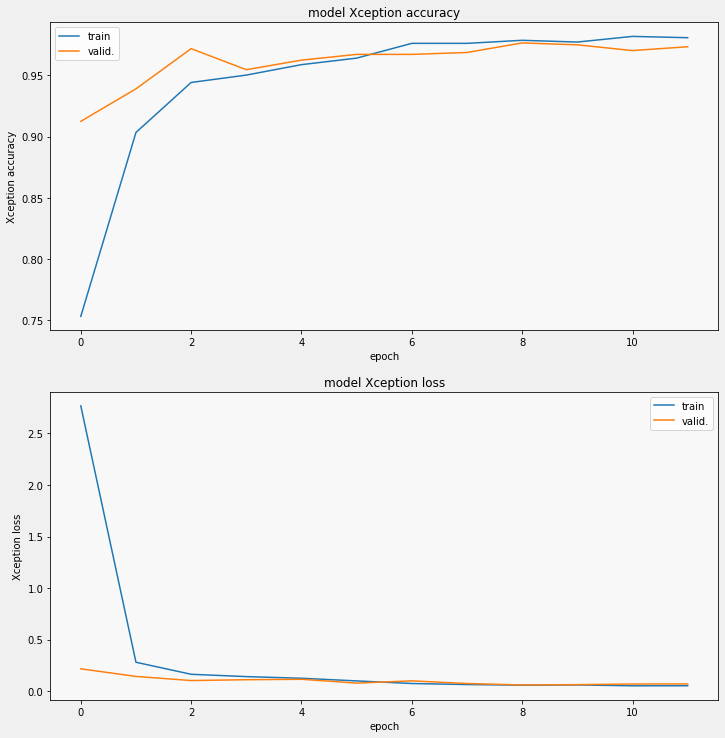

In [28]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Xception accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'Xception loss', 212)

# Train the model(VGG16)

In [29]:
start_time = time.time()
history = model_VGG16.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]


model_VGG16_accuracy=round(np.mean(final_accuracy),2)
model_VGG16_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(VGG16): ", model_VGG16_accuracy)
print("TRAINING TIME: ", model_VGG16_training_time , " sec")

Epoch 1/12
44/44 [==============================] - 32s 718ms/step - loss: 1.2107 - accuracy: 0.7337 - val_loss: 0.1906 - val_accuracy: 0.9156
Epoch 2/12
44/44 [==============================] - 31s 714ms/step - loss: 0.2499 - accuracy: 0.9141 - val_loss: 0.1372 - val_accuracy: 0.9438
Epoch 3/12
44/44 [==============================] - 31s 714ms/step - loss: 0.1693 - accuracy: 0.9393 - val_loss: 0.0956 - val_accuracy: 0.9609
Epoch 4/12
44/44 [==============================] - 31s 710ms/step - loss: 0.1245 - accuracy: 0.9599 - val_loss: 0.0815 - val_accuracy: 0.9656
Epoch 5/12
44/44 [==============================] - 31s 715ms/step - loss: 0.0954 - accuracy: 0.9709 - val_loss: 0.0735 - val_accuracy: 0.9656
Epoch 6/12
44/44 [==============================] - 31s 715ms/step - loss: 0.0789 - accuracy: 0.9783 - val_loss: 0.1025 - val_accuracy: 0.9547
Epoch 7/12
44/44 [==============================] - 31s 715ms/step - loss: 0.0704 - accuracy: 0.9794 - val_loss: 0.0577 - val_accuracy: 0.9734

# Training and Validation Accuracy Graph(VGG16)
# Training and Validation Loss Graph(VGG16)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


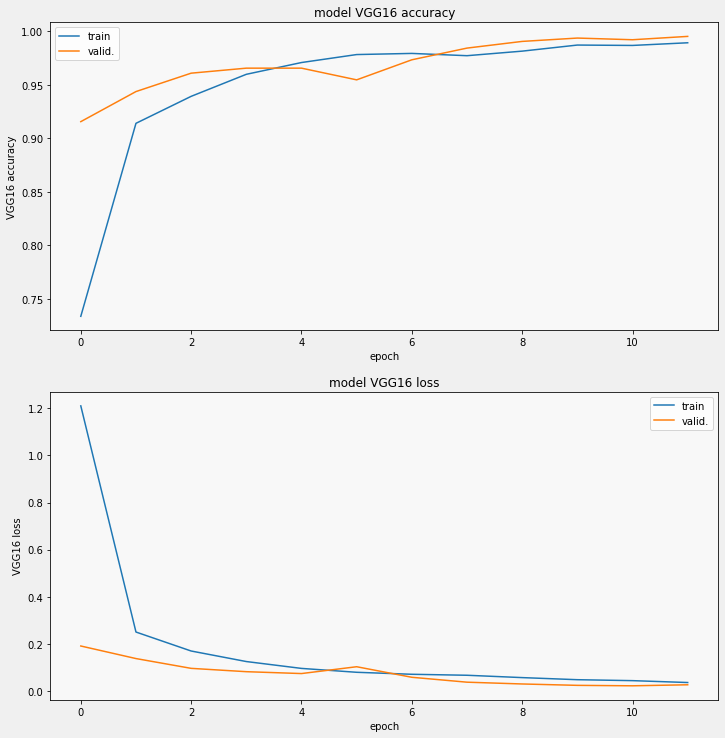

In [30]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'VGG16 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'VGG16 loss', 212)

# Train the model(VGG19)

In [31]:
start_time = time.time()
history = model_VGG19.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]

model_VGG19_accuracy=round(np.mean(final_accuracy),2)
model_VGG19_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(VGG19): ", model_VGG19_accuracy)
print("TRAINING TIME: ", model_VGG19_training_time , " sec")

Epoch 1/12
44/44 [==============================] - 37s 849ms/step - loss: 1.3454 - accuracy: 0.7290 - val_loss: 0.2272 - val_accuracy: 0.9109
Epoch 2/12
44/44 [==============================] - 37s 843ms/step - loss: 0.2478 - accuracy: 0.9155 - val_loss: 0.1688 - val_accuracy: 0.9312
Epoch 3/12
44/44 [==============================] - 37s 845ms/step - loss: 0.1594 - accuracy: 0.9485 - val_loss: 0.1097 - val_accuracy: 0.9625
Epoch 4/12
44/44 [==============================] - 37s 845ms/step - loss: 0.1214 - accuracy: 0.9620 - val_loss: 0.0930 - val_accuracy: 0.9719
Epoch 5/12
44/44 [==============================] - 37s 844ms/step - loss: 0.1079 - accuracy: 0.9659 - val_loss: 0.0767 - val_accuracy: 0.9766
Epoch 6/12
44/44 [==============================] - 37s 845ms/step - loss: 0.0815 - accuracy: 0.9741 - val_loss: 0.0580 - val_accuracy: 0.9812
Epoch 7/12
44/44 [==============================] - 37s 840ms/step - loss: 0.0678 - accuracy: 0.9798 - val_loss: 0.0763 - val_accuracy: 0.9703

# Training and Validation Accuracy Graph(VGG19)
# Training and Validation Loss Graph(VGG19)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


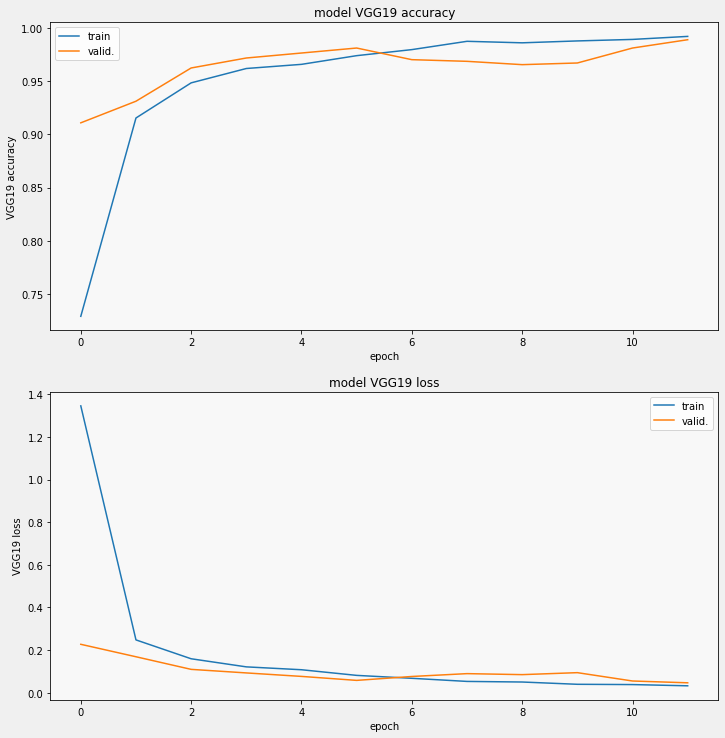

In [32]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'VGG19 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'VGG19 loss', 212)

# Train the model(InceptionResNetV2)

In [33]:
start_time = time.time()
history = model_InceptionResNetV2.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]

model_InceptionResNetV2_accuracy=round(np.mean(final_accuracy),2)
model_InceptionResNetV2_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(InceptionResNetV2): ", model_InceptionResNetV2_accuracy)
print("TRAINING TIME: ", model_InceptionResNetV2_training_time , " sec")

Epoch 1/12
44/44 [==============================] - 45s 1s/step - loss: 5.2161 - accuracy: 0.6815 - val_loss: 0.2899 - val_accuracy: 0.8891
Epoch 2/12
44/44 [==============================] - 41s 926ms/step - loss: 0.3656 - accuracy: 0.8622 - val_loss: 0.1868 - val_accuracy: 0.9375
Epoch 3/12
44/44 [==============================] - 41s 930ms/step - loss: 0.2759 - accuracy: 0.8924 - val_loss: 0.1353 - val_accuracy: 0.9594
Epoch 4/12
44/44 [==============================] - 41s 929ms/step - loss: 0.2259 - accuracy: 0.9176 - val_loss: 0.0899 - val_accuracy: 0.9719
Epoch 5/12
44/44 [==============================] - 41s 930ms/step - loss: 0.1769 - accuracy: 0.9361 - val_loss: 0.0863 - val_accuracy: 0.9656
Epoch 6/12
44/44 [==============================] - 41s 931ms/step - loss: 0.1751 - accuracy: 0.9371 - val_loss: 0.1565 - val_accuracy: 0.9469
Epoch 7/12
44/44 [==============================] - 41s 931ms/step - loss: 0.1946 - accuracy: 0.9219 - val_loss: 0.1214 - val_accuracy: 0.9609
Ep

# Training and Validation Accuracy Graph(InceptionResNetV2)
# Training and Validation Loss Graph(InceptionResNetV2)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


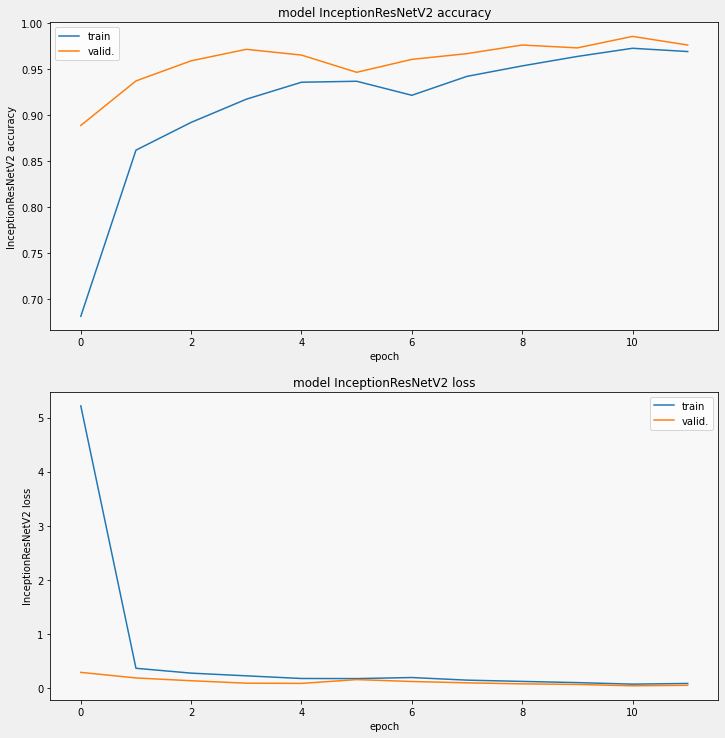

In [34]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'InceptionResNetV2 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'InceptionResNetV2 loss', 212)

# Train the model(InceptionV3)

In [35]:
start_time = time.time()
history = model_InceptionV3.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]

model_InceptionV3_accuracy=round(np.mean(final_accuracy),2)
model_InceptionV3_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(InceptionV3): ", model_InceptionV3_accuracy)
print("TRAINING TIME: ", model_InceptionV3_training_time , " sec")

Epoch 1/12
44/44 [==============================] - 18s 409ms/step - loss: 4.9490 - accuracy: 0.7287 - val_loss: 0.2913 - val_accuracy: 0.9141
Epoch 2/12
44/44 [==============================] - 16s 375ms/step - loss: 0.2713 - accuracy: 0.9105 - val_loss: 0.2205 - val_accuracy: 0.9312
Epoch 3/12
44/44 [==============================] - 17s 375ms/step - loss: 0.2077 - accuracy: 0.9247 - val_loss: 0.1894 - val_accuracy: 0.9391
Epoch 4/12
44/44 [==============================] - 16s 374ms/step - loss: 0.1986 - accuracy: 0.9222 - val_loss: 0.2041 - val_accuracy: 0.9312
Epoch 5/12
44/44 [==============================] - 16s 375ms/step - loss: 0.1576 - accuracy: 0.9453 - val_loss: 0.1574 - val_accuracy: 0.9484
Epoch 6/12
44/44 [==============================] - 16s 373ms/step - loss: 0.1360 - accuracy: 0.9478 - val_loss: 0.1483 - val_accuracy: 0.9484
Epoch 7/12
44/44 [==============================] - 16s 370ms/step - loss: 0.1264 - accuracy: 0.9531 - val_loss: 0.1722 - val_accuracy: 0.9453

# Training and Validation Accuracy Graph(InceptionV3)
# Training and Validation Loss Graph(InceptionV3)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


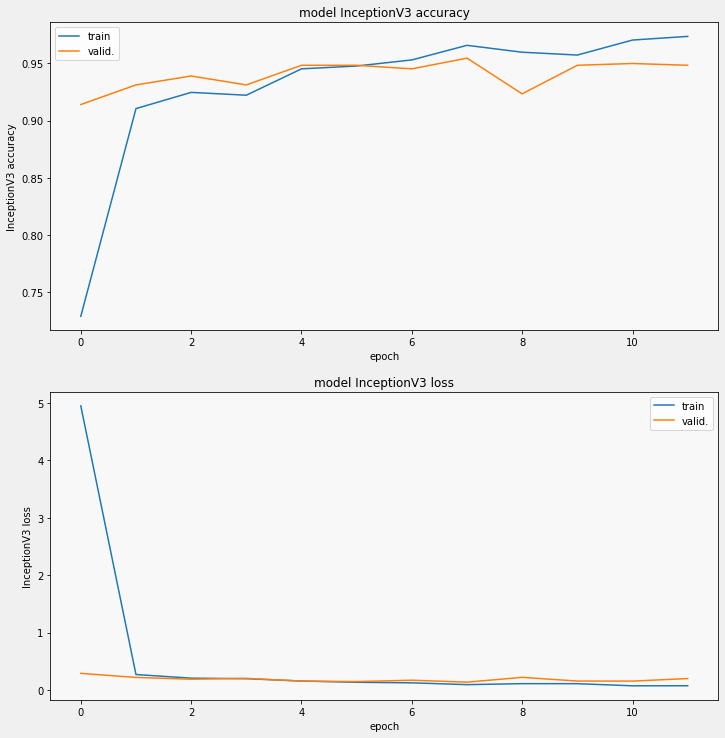

In [36]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'InceptionV3 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'InceptionV3 loss', 212)

In [37]:
training_details = [ 
        { 
        "Model": [{"Accuracy": model_MobileNetV2_accuracy, "Training Time": model_MobileNetV2_training_time} 
                   ], 
        "Name": "MobileNetV2"
        }, 
        { 
        "Model": [{"Accuracy": model_ResNet50V2_accuracy, "Training Time": model_ResNet50V2_training_time}                    
                  ], 
        "Name": "ResNet50V2"
        },
        { 
        "Model": [{"Accuracy": model_ResNet101V2_accuracy, "Training Time": model_ResNet101V2_training_time}                    
                  ], 
        "Name": "ResNet101V2"
        },
        { 
        "Model": [{"Accuracy": model_ResNet152V2_accuracy, "Training Time": model_ResNet152V2_training_time}                    
                  ], 
        "Name": "ResNet152V2"
        },
        { 
        "Model": [{"Accuracy": model_Xception_accuracy, "Training Time": model_Xception_training_time}                    
                  ], 
        "Name": "Xception"
        },
        { 
        "Model": [{"Accuracy": model_VGG16_accuracy, "Training Time": model_VGG16_training_time}                    
                  ], 
        "Name": "VGG16"
        },
        { 
        "Model": [{"Accuracy": model_VGG19_accuracy, "Training Time": model_VGG19_training_time}                    
                  ], 
        "Name": "VGG19"
        },
        { 
        "Model": [{"Accuracy": model_InceptionResNetV2_accuracy, "Training Time": model_InceptionResNetV2_training_time}                    
                  ], 
        "Name": "InceptionResNetV2"
        },
        { 
        "Model": [{"Accuracy": model_InceptionV3_accuracy, "Training Time": model_InceptionV3_training_time}                    
                  ], 
        "Name": "InceptionV3"
        }
       ] 

In [38]:
training_details

[{'Model': [{'Accuracy': 0.98, 'Training Time': 117.47}],
  'Name': 'MobileNetV2'},
 {'Model': [{'Accuracy': 0.98, 'Training Time': 265.21}],
  'Name': 'ResNet50V2'},
 {'Model': [{'Accuracy': 0.98, 'Training Time': 462.1}],
  'Name': 'ResNet101V2'},
 {'Model': [{'Accuracy': 0.98, 'Training Time': 669.28}],
  'Name': 'ResNet152V2'},
 {'Model': [{'Accuracy': 0.97, 'Training Time': 450.77}], 'Name': 'Xception'},
 {'Model': [{'Accuracy': 0.99, 'Training Time': 389.4}], 'Name': 'VGG16'},
 {'Model': [{'Accuracy': 0.97, 'Training Time': 455.37}], 'Name': 'VGG19'},
 {'Model': [{'Accuracy': 0.98, 'Training Time': 517.51}],
  'Name': 'InceptionResNetV2'},
 {'Model': [{'Accuracy': 0.94, 'Training Time': 208.38}],
  'Name': 'InceptionV3'}]

In [39]:
model_name=['MobileNetV2', 'ResNet50V2','ResNet101V2','ResNet152V2','Xception','VGG16','VGG19','InceptionResNetV2','InceptionV3']
model_accuracy=[model_MobileNetV2_accuracy, model_ResNet50V2_accuracy ,model_ResNet101V2_accuracy,model_ResNet152V2_accuracy,model_Xception_accuracy,model_VGG16_accuracy,model_VGG19_accuracy,model_InceptionResNetV2_accuracy,model_InceptionV3_accuracy]
model_training_time=[model_MobileNetV2_training_time,model_ResNet50V2_training_time,model_ResNet101V2_training_time,model_ResNet152V2_training_time,model_Xception_training_time,model_VGG16_training_time,model_VGG19_training_time,model_InceptionResNetV2_training_time,model_InceptionV3_training_time]

In [40]:
import pandas as pd 

df = pd.DataFrame(list(zip(model_name, model_accuracy,model_training_time )), 
               columns =['Model Name', 'Accuracy', 'Training Time']) 
df 

Model Name  Accuracy  Training Time
0        MobileNetV2      0.98         117.47
1         ResNet50V2      0.98         265.21
2        ResNet101V2      0.98         462.10
3        ResNet152V2      0.98         669.28
4           Xception      0.97         450.77
5              VGG16      0.99         389.40
6              VGG19      0.97         455.37
7  InceptionResNetV2      0.98         517.51
8        InceptionV3      0.94         208.38

In [41]:
df['Training Time'] = np.log(df['Training Time'])

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


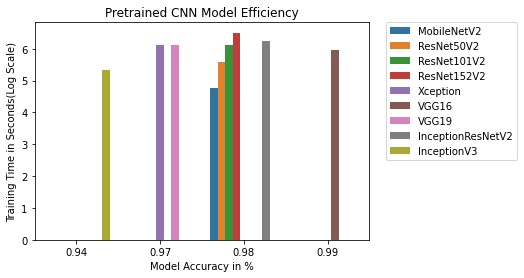

In [43]:
ax=sns.barplot(y="Training Time", x="Accuracy", hue="Model Name", data=df)
ax.set_title('Pretrained CNN Model Efficiency')
ax.set_ylabel('Training Time in Seconds(Log Scale)')
ax.set_xlabel('Model Accuracy in %')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Predictions

[b'Healthy', b'Cedar_Rust', b'Healthy', b'Healthy', b'Cedar_Rust', b'Healthy', b'Scab', b'Scab', b'Healthy']


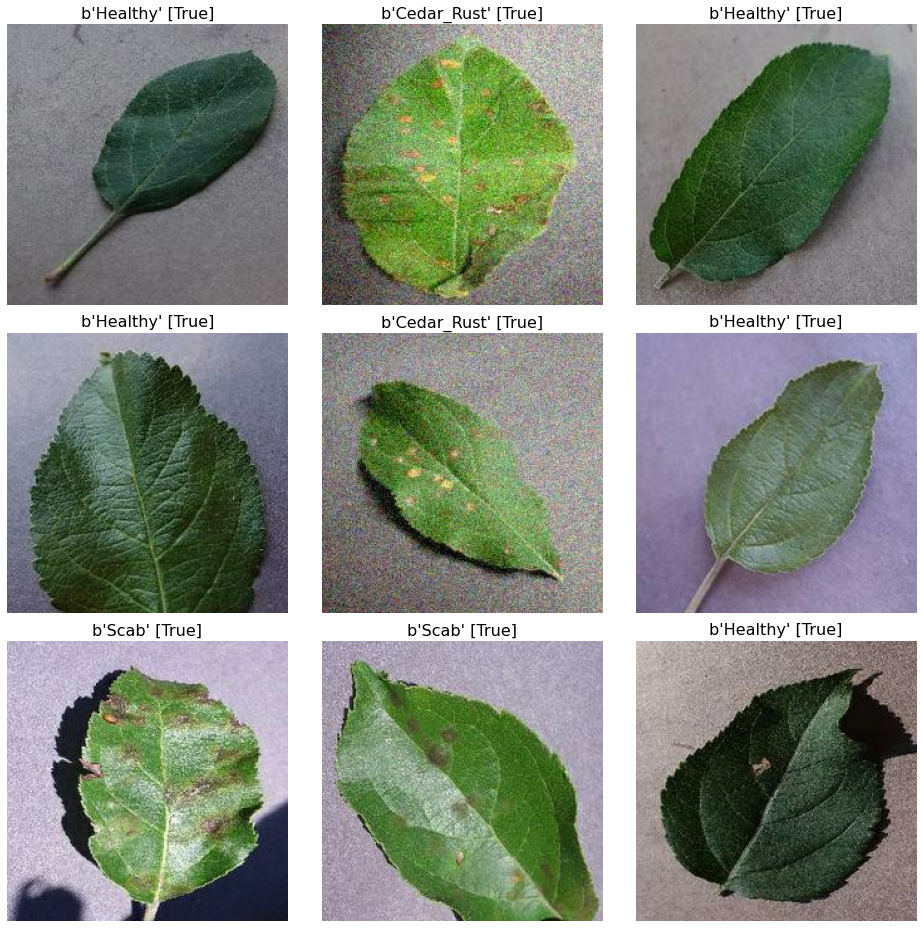

In [44]:
# random input: execute multiple times to change results
#print(load_dataset(validation_filenames.skip(np.random.randint(300)))
potatos, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(16)), 9)

predictions = model_MobileNetV2.predict(potatos, steps=1 )
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
#print(validation_filenames)

display_9_images_with_predictions(potatos, predictions, labels)

# Save The Model



In [45]:
# Save JSON config to disk
json_config = model_MobileNetV2.to_json()
with open('/content/drive/My Drive/Plant_Disease_Clinic/Model/Apple/apple_model_config_MobileNetV2.json', 'w') as json_file:
    json_file.write(json_config)
# Save weights to disk
model_MobileNetV2.save_weights('/content/drive/My Drive/Plant_Disease_Clinic/Model/Apple/apple_weights_MobileNetV2.h5')

# Reload the model from the 2 files we saved
with open('/content/drive/My Drive/Plant_Disease_Clinic/Model/Apple/apple_model_config_MobileNetV2.json') as json_file:
     json_config = json_file.read()
my_saved_model = tf.keras.models.model_from_json(json_config)
my_saved_model.load_weights('/content/drive/My Drive/Plant_Disease_Clinic/Model/Apple/apple_weights_MobileNetV2.h5')


# Load The Saved Model

In [46]:
print(my_saved_model.summary())
print(my_saved_model.input_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               16056576  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 18,315,588
Trainable params: 16,057,604
Non-trainable params: 2,257,984
_________________________________________________________________
None
(None, 224, 224, 3)


# Predict From Saved Model

[b'Scab', b'Scab', b'Scab', b'Healthy', b'Healthy', b'Black_Rot', b'Healthy', b'Healthy', b'Scab']


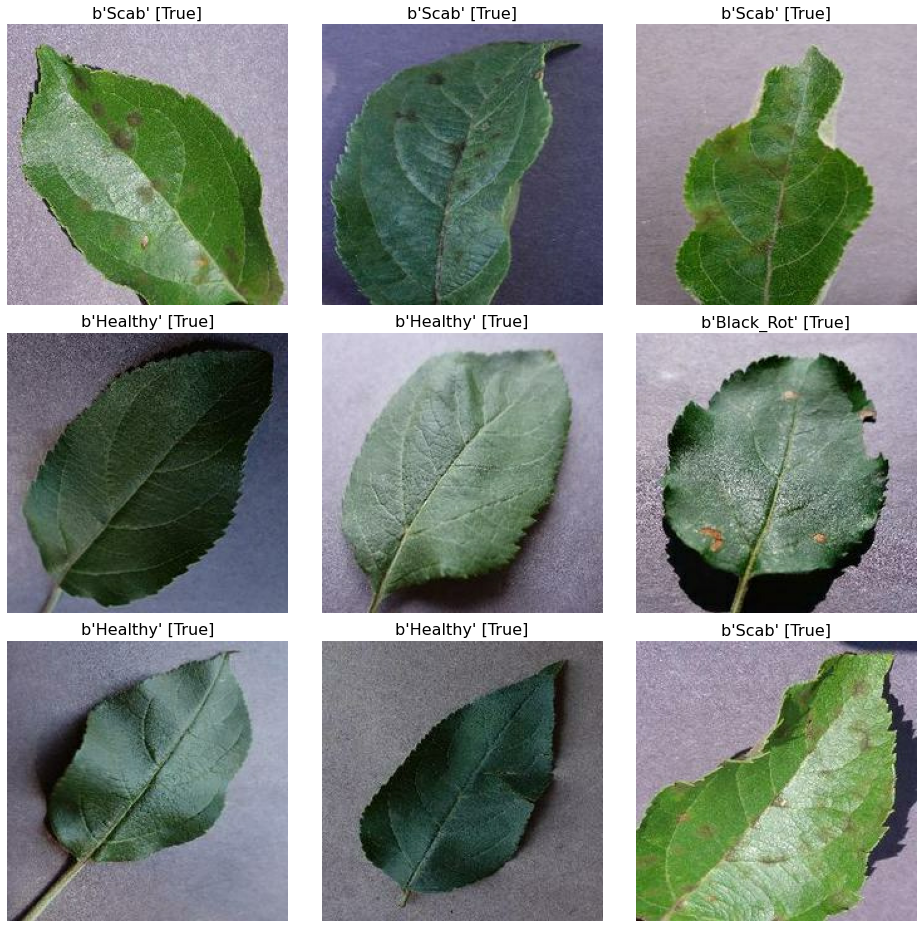

In [47]:
# random input: execute multiple times to change results
potatos, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(30)), 9)
predictions = my_saved_model.predict(potatos, steps=1 )
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
display_9_images_with_predictions(potatos, predictions, labels)